# Analysis of subsetted *ex vivo* HPSC differentiation (LARRY) using MEGATRON

**Data from:**
Weinreb, C., Rodriguez-Fraticelli, A., Camargo, F. D., & Klein, A. M. (2020). Lineage tracing on transcriptional landscapes links state to fate during differentiation. Science, 367(6479), eaaw3381. https://doi.org/10.1126/science.aaw3381

In [35]:
import megatron as me
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import scanpy as sc

In [36]:
me.__version__

'0.1a'

In [37]:
workdir = 'result_larry_subset'
me.settings.set_workdir(workdir)

Saving results in: result_larry_subset


In [38]:
me.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

# Read in the input data

In [39]:
adata = me.read_h5ad('./larry_input/subset/rnaseq_weinreb20_invitro_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    obsm: 'X_SPRING'

In [40]:
mat_clones = load_npz('./larry_input/subset/clones_weinreb20_invitro_subset.npz')
mat_clones

<3221x5864 sparse matrix of type '<class 'numpy.int64'>'
	with 3221 stored elements in Compressed Sparse Column format>

In [41]:
me.pp.add_clones(adata, 
                 mat=mat_clones)
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

In [42]:
me.pp.filter_clones(adata,min_cells=1)
adata

Before filtering: 5864 clones
After filtering: 365 clones


AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

hi!
hi!


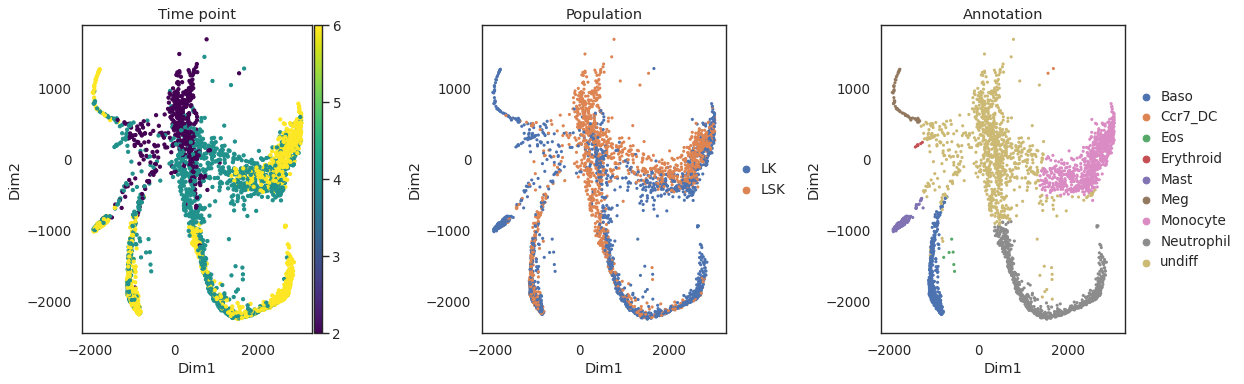

In [43]:
me.pl.scatter(adata, 
              color=['Time point','Population','Annotation'],
              drawing_order='random',
              obsm='X_SPRING')

# Calculate clonal trajectory distances

In [44]:
me.tl.clone_distance(adata,
                     method='geodesic',
                     obsm='X_SPRING',
                     anno_time='Time point',
                     n_jobs=4)

Finished: 0.5883697986602783 mins


In [45]:
adata.uns['clone'].keys()

dict_keys(['anno', 'distance_geodesic', 'distance'])

In [46]:
me.tl.cluster_clones(adata,
                     n_clusters=6,
                     method='hierarchical')

In [47]:
adata.uns['clone']['anno'].head()

,hierarchical
50,5
82,6
105,3
111,5
134,4


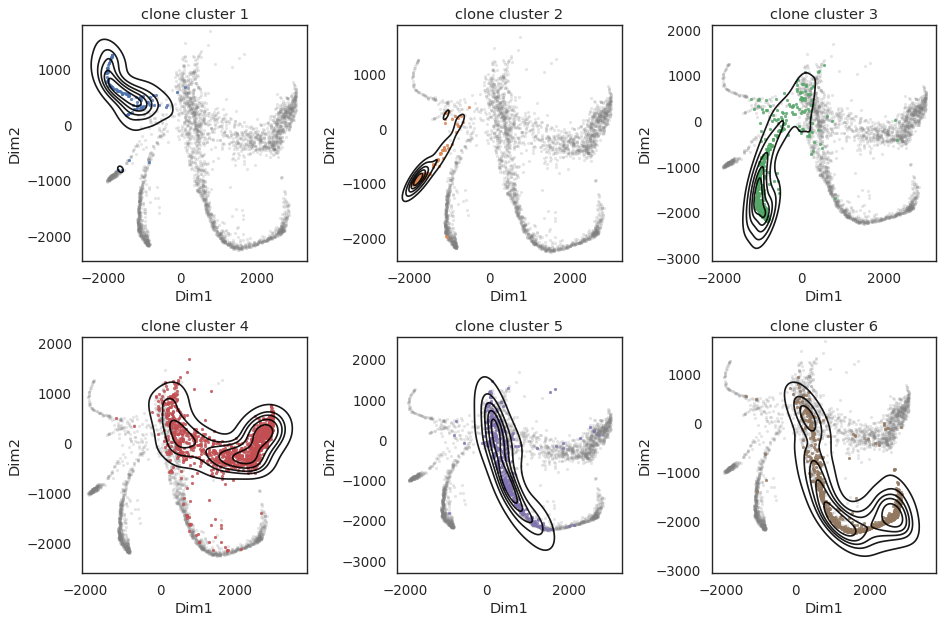

In [48]:
me.pl.clone_clusters(adata, group='hierarchical', obsm='X_SPRING',show_contour=True, 
                    levels=6, thresh=0.1)

# Compare our distance calculations to a ground truth

In [49]:
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score

df_truth = pd.read_csv('./larry_input/subset/clones_truth.tsv.gz',sep='\t',index_col=0)
all(df_truth.index.astype(str) == adata.uns['clone']['anno'].index)

True

In [50]:
adjusted_rand_score(df_truth['celltype'].tolist(),  adata.uns['clone']['anno']['hierarchical'].tolist())

0.8240474981576086

# Identify genes differentially expressed between clone cluster 4 and clone cluster 6

graph already built, using previous (set force=True to clobber)


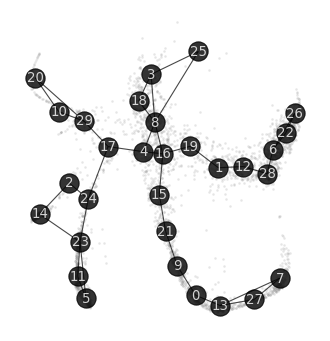

In [51]:
me.tl.build_graph(adata, obsm='X_SPRING', k=3, n_clusters=30)
me.pl.cluster_graph(adata, obsm='X_SPRING', node_color="black", alpha=0.8)

graph already built, using previous (set force=True to clobber)


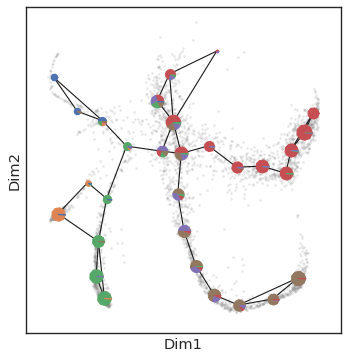

In [52]:
# Logan -- this one!
# %load_ext autoreload
%autoreload
me.pl.cluster_pie_graph(adata, obsm="X_SPRING")

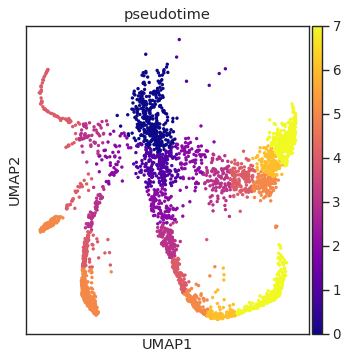

In [53]:
progenitor_clusters = [3, 18, 8]
me.tl.calculate_pseudotime(adata, progenitor_clusters)
adata.obs['pseudotime']=adata.uns['cluster_pseudotime'].loc[adata.obs['cluster']].values
adata.obsm['umap'] = adata.obsm['X_SPRING']
sc.pl.umap(adata,color=['pseudotime'], cmap='plasma')

In [54]:
adata.obs

,Time point,Population,Annotation,Well,cluster,metaclone,pseudotime
84,6.0,LK,Mast,2,14,2,5
115,6.0,LK,Monocyte,2,26,4,7
190,6.0,LK,Mast,2,14,2,5
205,6.0,LK,Mast,2,14,2,5
337,6.0,LK,Meg,2,20,1,4
...,...,...,...,...,...,...,...
130563,6.0,LSK,Neutrophil,1,0,5,5
130686,6.0,LSK,Monocyte,1,22,4,7
130735,6.0,LSK,Neutrophil,1,0,6,5
130740,6.0,LSK,Monocyte,1,12,4,4


In [55]:
progenitor_cells = adata[adata.obs['pseudotime'] == 6.0]
progenitor_cells.obs

,Time point,Population,Annotation,Well,cluster,metaclone,pseudotime
644,6.0,LK,Monocyte,2,6,4,6
1139,6.0,LK,Monocyte,2,6,4,6
1776,6.0,LK,Neutrophil,2,13,6,6
2115,6.0,LK,Neutrophil,2,13,6,6
3412,6.0,LK,Neutrophil,2,13,6,6
...,...,...,...,...,...,...,...
129074,6.0,LSK,Monocyte,1,6,4,6
129266,6.0,LSK,Monocyte,1,6,4,6
129406,6.0,LSK,Monocyte,1,6,4,6
129483,6.0,LSK,Monocyte,1,6,4,6


In [56]:
progenitor_cells

View of AnnData object with n_obs × n_vars = 251 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well', 'cluster', 'metaclone', 'pseudotime'
    uns: 'clone', 'color', 'cluster_pos', 'cluster_pdist', 'cluster_edgelist', 'cluster_pseudotime'
    obsm: 'X_SPRING', 'X_clone', 'umap'

In [65]:
# and this one 

group1 = ['4'] # the first metaclone to test against
group2 = ['6'] # the second metaclone to test against

# me.tl.differential_test_vars(progenitor_cells, group1, group2, test="t-test")
me.tl.differential_test_vars(progenitor_cells, group1, group2, test="wilcoxon")

/srv/local/logan/mambaforge/envs/logan_MEGATRON/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''